## **Load *Monod*+meK-Means and Packages**

In [48]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [49]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [50]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import os

import sklearn
import scanpy as sc
import anndata

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Load Metadata and Select Genes for Inference Across Conditions**

In [52]:
#Test with controls for now, and remove later if necessary 

In [53]:
meta_path = "/home/tchari/metadata/"
meta = pd.read_csv(meta_path+'norman_GSE133344_filtered_cell_identities.csv')
meta.head()

,cell_barcode,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells
0,TTGAACGAGACTCGGA-2,ARID1A_NegCtrl0__ARID1A_NegCtrl0,28684,1809,15.856274,2,True,1
1,CGTTGGGGTGTTTGTG-7,BCORL1_NegCtrl0__BCORL1_NegCtrl0,18367,896,20.498884,7,True,1
2,GAACCTAAGTGTTAGA-6,FOSB_NegCtrl0__FOSB_NegCtrl0,16296,664,24.542169,6,True,1
3,CCTTCCCTCCGTCATC-4,SET_KLF1__SET_KLF1,16262,850,19.131765,4,True,1
4,TCAATCTGTCTTTCAT-2,OSR2_NegCtrl0__OSR2_NegCtrl0,16057,1067,15.048735,2,True,2


In [54]:
ids = list(meta['guide_identity'].value_counts().index)
counts = list(meta['guide_identity'].value_counts())

saveCounts = pd.DataFrame()
saveCounts['guide_identity'] = ids
saveCounts['cells'] = counts
saveCounts.head()

,guide_identity,cells
0,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,3532
1,NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0,2948
2,NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0,2839
3,NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0,2536
4,CEBPE_RUNX1T1__CEBPE_RUNX1T1,1219


In [68]:
saveCounts[saveCounts['guide_identity'].isin(['NegCtrl0_MAPK1__NegCtrl0_MAPK1'])]

,guide_identity,cells
68,NegCtrl0_MAPK1__NegCtrl0_MAPK1,446


In [66]:
saveCounts[saveCounts['guide_identity'].isin(['DUSP9_NegCtrl0__DUSP9_NegCtrl0'])]

,guide_identity,cells
14,DUSP9_NegCtrl0__DUSP9_NegCtrl0,731


In [1686]:
[i for i in saveCounts['guide_identity'] if 'MAPK1' in i]

['MAPK1_PRTG__MAPK1_PRTG',
 'MAPK1_TGFBR2__MAPK1_TGFBR2',
 'ETS2_MAPK1__ETS2_MAPK1',
 'NegCtrl0_MAPK1__NegCtrl0_MAPK1',
 'CEBPB_MAPK1__CEBPB_MAPK1',
 'CNN1_MAPK1__CNN1_MAPK1',
 'IGDCC3_MAPK1__IGDCC3_MAPK1',
 'MAPK1_NegCtrl0__MAPK1_NegCtrl0',
 'MAPK1_IKZF3__MAPK1_IKZF3',
 'DUSP9_MAPK1__DUSP9_MAPK1']

In [1256]:
saveCounts[saveCounts['guide_identity'].isin(['ETS2_NegCtrl0__ETS2_NegCtrl0'])]

,guide_identity,cells
64,ETS2_NegCtrl0__ETS2_NegCtrl0,451


Filter for conditions with > 100 cells (since we're looking for possible subpopulations/states etc)

In [104]:

# ctrls = ['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0','NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0',
# 'NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0','NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0']

#ctrls = ['DUSP9_MAPK1__DUSP9_MAPK1','DUSP9_NegCtrl0__DUSP9_NegCtrl0','NegCtrl0_MAPK1__NegCtrl0_MAPK1' ]
ctrls = ['DUSP9_ETS2__DUSP9_ETS2','ETS2_NegCtrl0__ETS2_NegCtrl0','DUSP9_NegCtrl0__DUSP9_NegCtrl0']

ctrl_bars = list(meta.cell_barcode[meta.guide_identity.isin(ctrls)])

#conds_only = list(saveCounts['guide_identity'][(saveCounts['cells'] >  500) & (~saveCounts['guide_identity'].isin(ctrls))])
#conds_only = ['NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0']

#conds_only = ['DUSP9_MAPK1__DUSP9_MAPK1','DUSP9_NegCtrl0__DUSP9_NegCtrl0','NegCtrl0_MAPK1__NegCtrl0_MAPK1' ]
#'DUSP9_MAPK1__DUSP9_MAPK1','MAPK1_NegCtrl0__MAPK1_NegCtrl0'
#['DUSP9_ETS2__DUSP9_ETS2','ETS2_NegCtrl0__ETS2_NegCtrl0','DUSP9_NegCtrl0__DUSP9_NegCtrl0']

filt_ids = ctrls   #conds_only+
#list(saveCounts['guide_identity'][(saveCounts['cells'] >  100) & ~saveCounts['guide_identity'].isin(ctrls)])
len(filt_ids)

3

In [105]:
filt_bars = list(meta.cell_barcode[meta.guide_identity.isin(filt_ids)])

In [106]:
# filt_conds_bars = list(meta.cell_barcode[meta.guide_identity.isin(conds_only)])

**For all pair conditions, find matching single conds and extract important genes**

In [107]:
import random

In [109]:
#Get full count matrices and barcodes
ds = lp.connect('/home/tchari/counts/norman_crispr/loom/allcrispr.loom')
U = ds.layers['unspliced'][:].T
S = ds.layers['spliced'][:].T
bars = ds.ca['barcode']
g_names = ds.ra['gene_name']
ds.close()

In [110]:
cf = pd.Categorical(bars).isin(filt_bars)
order_bars = bars[cf]

In [111]:
S_sub = S[cf,:]
U_sub = U[cf,:]

In [112]:
subclass = [list(meta['guide_identity'][meta['cell_barcode'] == i])[0] for i in order_bars]

In [113]:
len(order_bars)

1969

In [114]:
retAdata = anndata.AnnData(
    X=S_sub,
    layers={
        'spliced': S_sub,
        'unspliced': U_sub
    },
    obs=pd.DataFrame({'barcode': order_bars,'subclass_label':subclass},
                     index=order_bars),
    var=pd.DataFrame({'gene_name': g_names},index=g_names)
)

retAdata.write_loom('./norman_meK.loom')

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## **Set up Files for Inference and Select Cell Barcodes**

In [115]:
Ks = [3,5] #K options for meK-Means
num_ks = len(Ks) #Number of Ks to try

In [116]:
#Set  up output file names for inference run results

#Make names for each of the K runs
clus_names = ['k'+str(run_k) for run_k in Ks]

#Output file names
dataset_names = ['meK_norman_'+y  for y in clus_names]
print('Runs: ',dataset_names)

Runs:  ['meK_norman_k3', 'meK_norman_k5']


In [117]:
#Set reference data filepaths
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

#Attribute names in loom file, same as in standard kallisto|bustools --lamanno output
attribute_names=[('unspliced','spliced'),'gene_name','barcode']

l='./norman_meK.loom'
loom_filepaths = [l]*num_ks #All runs use the same loom file
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

loom_filepaths:  ['./norman_meK.loom', './norman_meK.loom']


Filter for barcodes in selected conditions + with UMI threshold

## **Create Output Files and Run meK-Means**

In [118]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [119]:
#Threshold for filtering genes based on expression patterns
def nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02):
    '''
    Take in U,S matrices, and find genes that meet var/mean thresh
    U,S are cellxgene
    '''
    var_threshold = var_t
    U_mean = U.mean(0)
    S_mean = S.mean(0)
    U_var = U.var(0)
    S_var = S.var(0)

    #if l == '/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01A02_raw.loom':
    u_min = u_min
    s_min =  s_min


    fitted_idx = (U_mean > u_min) & (S_mean > s_min) \
    & (((U_var-U_mean)/(U_mean**2)) > var_threshold)\
    & (((S_var-S_mean)/(S_mean**2)) > var_threshold)\
    & (np.abs(np.log(S_mean/U_mean)) < 4) 
    #((U_mean/S_mean) > 1.0) #labeled mRNA (new synth) is mainly intronic counts
    
    #(np.abs(np.log(S_mean/U_mean)) < 4) 
    
    
    return fitted_idx

In [120]:
def check_at_bounds(phys_params,thr=0.01,phys_lb=[-2.0, -1.8, -1.8 ],phys_ub=[4.2, 2.5, 2.5]):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [121]:
def get_assigns(sr):
    '''
    Get cell cluster assignments
    '''
    cats = np.array([None]*len(sr[0].filt))
    for r in sr:
        cats[r.filt] = r.assigns
    return cats

In [122]:
def print_summary(sr):
    '''
    Get summary of clustering results
    '''
    print('--------------------------')
    print('Model AIC Score: ',sr[0].aic[0])
    for r in sr:
        print('Clus '+str(r.assigns)+' with '+str(np.sum(r.filt))+' cells')
    print('--------------------------')

In [123]:
def vis_metrics(results,title,ks,figsize=(18, 5),s=50,fname=None):
    '''
    Visualize -Q function and KLD over epochs, and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))


    #Plot klds over epochs
    g2=sns.lineplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final Assigned k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)


In [124]:
#Plot cluster concordance with true labels and distribution of clusters

def vis_assign(assign,true=None,title='',log=True,figsize=(18, 5),palette='tab20',fname=None):
    '''
    Plot distribution of cluster assignments (optional: with previous annotations)

    assign: np.array of cluster assignments (1..k) for each cell
    true: list of user-given cluster assignments (string) for each cell, optional
    title: title string for cluster assignment plot
    figsize: tuple for size of figure
    save_file: string, output file to save image

    '''
 
    #Plot cluster assignments and distribution of sizes of each cluster
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    if true is not None:
        hues = true
    else:
        hues = assign 
        
    if log:
        plt.yscale('log')
    
    g= sns.histplot(x=assign,hue=hues,hue_order=list(np.unique(hues)), kde=False,ax=ax,
                    palette=palette,multiple="dodge",
                    discrete=True)

    plt.xticks(np.arange(0,np.max(assign)+1))
    


    ax.set_xlabel('meK-Means Cluster Assignment')
    ax.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)



In [125]:
!mkdir ./fits

mkdir: cannot create directory ‘./fits’: File exists


In [126]:
# !rm -r ./fits/gg_240410_029_meK_norman_1

In [127]:
#Select to run inference on, same genes selected across all runs
#Make anndata with conditions and get most variable genes
ds = lp.connect(l)
U = ds.layers['unspliced'][:].T
S = ds.layers['spliced'][:].T
bars = ds.ca['barcode']
g_names = ds.ra['gene_name']
true_labs = ds.ca['subclass_label']
ds.close()


adata = anndata.AnnData(X=S)
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
g_filt_hvg = adata.var.highly_variable

#Filter for overdispersed *and* enough U/S counts for clustering
g_filt = nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02) #u_min =0.01,s_min =0.01
#g_filt_lit = pd.Categorical(g_names).isin(lit_genes)


final_filt =  (g_filt_hvg & g_filt) #| (g_filt_lit  & g_filt) #Filter hvgs + add lit genes
final_names = g_names[final_filt]

print(str(np.sum(final_filt)),' genes')


dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='meK_norman',batch_id=1,\
                                             n_genes=len(final_names),\
                                             exp_filter_threshold=None,
                                             viz=False,
                                             genes_to_fit=final_names) #genes_to_fit=all_gs_forinf,len(all_gs_forinf)


48  genes
INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_240410_029_meK_norman_1 created.
INFO:root:Dataset: meK_norman_k3
INFO:root:1969 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:1942 genes retained after expression filter.
INFO:root:Directory ./fits/gg_240410_029_meK_norman_1/meK_norman_k3 created.
INFO:root:Dataset: meK_norman_k5
INFO:root:1969 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:1942 genes retained after expression filter.
INFO:root:Directory ./fits/gg_240410_029_meK_norman_1/meK_norman_k5 created.
INFO:root:Total of 48 genes selected.


In [129]:
dir_string = './fits/gg_240410_029_meK_norman_1' #gg_230215_025_norman_crispr_all_1
dataset_strings = [dir_string+'/'+i for i in dataset_names]


**Run meK-Means**

In [130]:
#Set bounds from physical parameters search space
phys_lb = [-2.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 2.5]
samp_lb = [-7.157894736842105, -1.525]
samp_ub = [-7.157894736842105, -1.525]

gridsize = [1,1]

In [131]:
#Set number of epochs
epochs = 10

In [132]:
# saveCounts

In [133]:
result_strings = []
for i in range(num_ks):

    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=Ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names)

    #Run inference(fit_all_grid_points()) and Save result file strings
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data) 

    result_strings.append(full_result_string)
    

INFO:root:Directory ./fits/gg_240410_029_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_240410_029_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_norman_k3
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_240410_029_meK_norman_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_240410_029_meK_norman_1/meK_norman_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.64566744 0.07695698 0.27737558]
Q Function:  -87899.03889794902

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.8604797  0.00753673 0.13198358]
Q Function:  -87377.54938932111

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.91039445e-01 3.11944083e-06 1.08957436e-01]
Q Function:  -86242.96848377086

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.44066795e-01 5.08065971e-10 5.59332046e-02]
Q Function:  -86549.5837428294

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.57s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.69274662e-01 5.07872033e-10 3.07253372e-02]
Q Function:  -86473.0518976695

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.47381421e-01 5.07872026e-10 5.26185788e-02]
Q Function:  -86030.38017424506

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.63702411e-01 5.07872056e-10 3.62975885e-02]
Q Function:  -86295.6603021358

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.39217512e-01 5.07872022e-10 6.07824877e-02]
Q Function:  -85830.46875711982

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.13s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.73853887e-01 5.07872026e-10 2.61461129e-02]
Q Function:  -86527.35872222767

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.61723332e-01 5.07872033e-10 3.82766677e-02]
Q Function:  -86086.70695076694

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_240410_029_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/analysis_figures_0 created.
INFO:root:Directory ./fits/gg_240410_029_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/analysis_figures_2 created.
INFO:root:Runtime: 114.2 seconds.
INFO:root:Directory ./fits/gg_240410_029_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_240410_029_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_norman_k5
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_240410_029_meK_norman_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_240410_029_meK_norman_1/meK_norman_k5/raw.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.18it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.28it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.26678195 0.34899483 0.03459398 0.08018621 0.26944304]
Q Function:  -87768.5057258654

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.61872593 0.11303924 0.01579948 0.20694046 0.04549488]
Q Function:  -93830.93671867343

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.48it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66575181 0.13004761 0.00253961 0.18824313 0.01341784]
Q Function:  -86079.67231683235

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.78497666 0.13861895 0.00253923 0.07155315 0.00231201]
Q Function:  -87077.62226781595

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.56733522e-01 8.34279540e-02 2.52627877e-03 5.73122443e-02
 5.07920011e-10]
Q Function:  -86243.94467349313

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.11227345e-01 3.60603460e-02 2.53938088e-03 5.01729272e-02
 5.07872015e-10]
Q Function:  -86163.68901504023

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.00825810e-01 7.42815639e-02 2.50941216e-03 2.23832137e-02
 5.07872015e-10]
Q Function:  -86163.07881953158

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.75s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.93959601e-01 9.06142096e-02 2.53231515e-03 1.28938740e-02
 5.07872015e-10]
Q Function:  -86053.48522424581

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.72307180e-01 1.99164391e-02 3.04301035e-03 4.73337041e-03
 5.07872015e-10]
Q Function:  -86578.96458895503

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.94137814e-01 2.74160857e-03 2.96014943e-03 1.60426988e-04
 5.07872015e-10]
Q Function:  -86650.33341919484

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_240410_029_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/analysis_figures_0 created.
INFO:root:Directory ./fits/gg_240410_029_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/analysis_figures_1 created.
INFO:root:Directory ./fits/gg_240410_029_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/analysis_figures_2 created.
INFO:root:Runtime: 102.3 seconds.


In [134]:
result_strings

[['./fits/gg_240410_029_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/grid_scan_results_0.res',
  './fits/gg_240410_029_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/grid_scan_results_2.res'],
 ['./fits/gg_240410_029_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/grid_scan_results_0.res',
  './fits/gg_240410_029_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/grid_scan_results_1.res',
  './fits/gg_240410_029_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/grid_scan_results_2.res']]

In [135]:
#DOes more genes --> more clusters? Try doubling to top 200?

#Read in result files for K=1,5,7 runs
sr = []
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]

sr

INFO:root:Grid scan results loaded from ./fits/gg_240410_029_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/grid_scan_results_0.res.
INFO:root:Grid scan results loaded from ./fits/gg_240410_029_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/grid_scan_results_2.res.
INFO:root:Grid scan results loaded from ./fits/gg_240410_029_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/grid_scan_results_0.res.
INFO:root:Grid scan results loaded from ./fits/gg_240410_029_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/grid_scan_results_1.res.
INFO:root:Grid scan results loaded from ./fits/gg_240410_029_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/grid_scan_results_2.res.


[[<monod.mminference.SearchResults at 0x7f831a499810>,

In [136]:
raws = [d_string+'/raw.sd' for d_string in dataset_strings]
sd = [monod.analysis.load_search_data(w) for w in raws]
sd

INFO:root:Search data loaded from ./fits/gg_240410_029_meK_norman_1/meK_norman_k3/raw.sd.
INFO:root:Search data loaded from ./fits/gg_240410_029_meK_norman_1/meK_norman_k5/raw.sd.


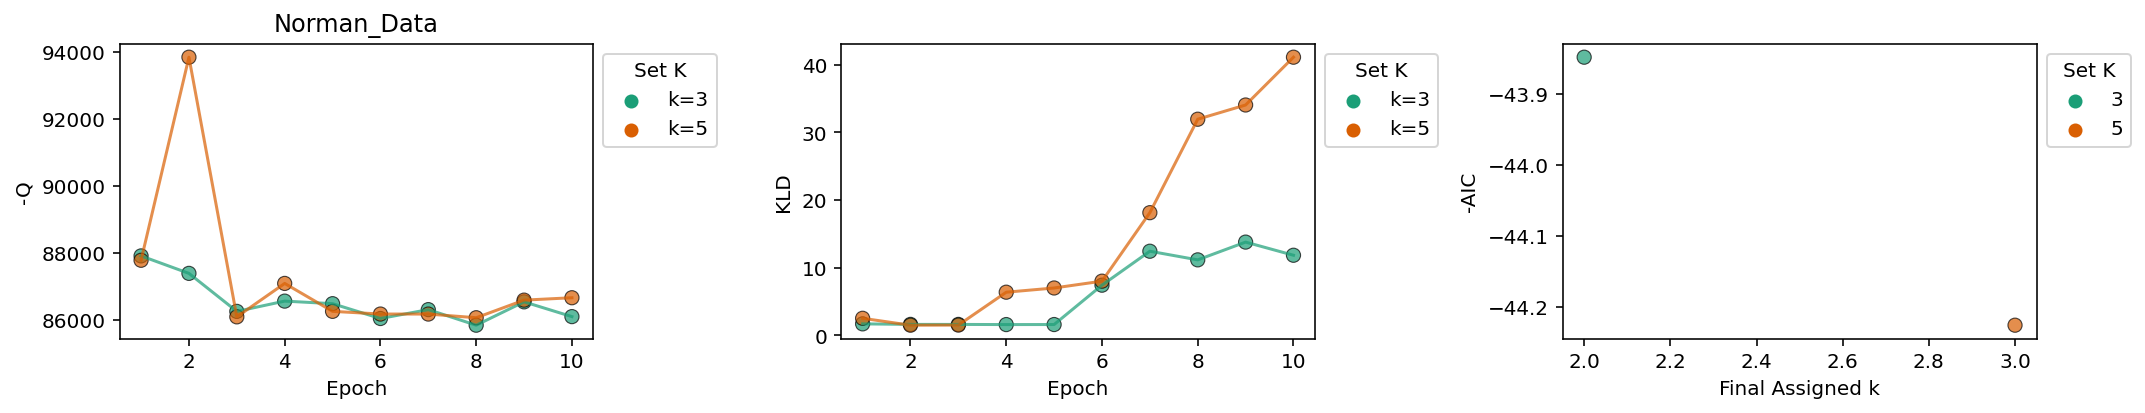

In [137]:
vis_metrics(sr,'Norman_Data',Ks,figsize=(15,3),fname='norman_k_metrics.pdf')

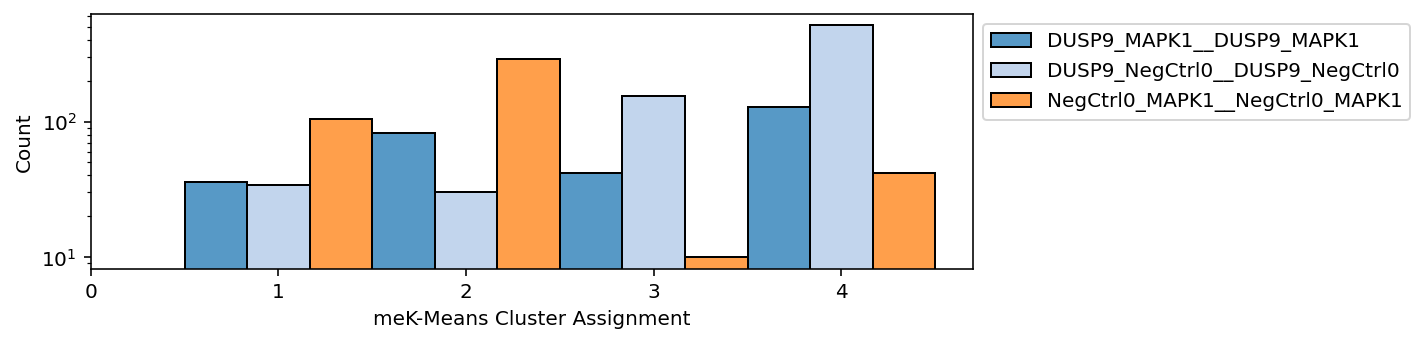

In [102]:
vis_assign(get_assigns(sr[1]),true=true_labs,title='',figsize=(10, 2.5),fname=None)

In [103]:
#Hard to interpret this data, and not much to compare to in original study